# But de ce tutoriel

Nous allons observer et comparer différentes métriques pour évaluer des modèles de classification :
* Précision
* Rappel
* F1-score
* AUC score

# Import des modules nécessaires

In [46]:
import numpy as np

import pandas as pd

# Import des données

Nous aurons plusieurs exemples.
1. Une analyse de churn (résiliation client) pour un opérateur télécom.

In [2]:
# https://query.data.world/s/jb75k2kxn5ajlcxsmvlnorxyj4pisx
df_churn = pd.read_csv('https://bit.ly/2Pkupqx')

df_churn.info()

df_churn.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
churn                         5000 non-null object
accountlength                 5000 non-null int64
internationalplan             5000 non-null object
voicemailplan                 5000 non-null object
numbervmailmessages           5000 non-null int64
totaldayminutes               5000 non-null float64
totaldaycalls                 5000 non-null int64
totaldaycharge                5000 non-null float64
totaleveminutes               5000 non-null float64
totalevecalls                 5000 non-null int64
totalevecharge                5000 non-null float64
totalnightminutes             5000 non-null float64
totalnightcalls               5000 non-null int64
totalnightcharge              5000 non-null float64
totalintlminutes              5000 non-null float64
totalintlcalls                5000 non-null int64
totalintlcharge               5000 non-null float64
numbercustomerservicecal

,churn,accountlength,internationalplan,voicemailplan,numbervmailmessages,totaldayminutes,totaldaycalls,totaldaycharge,totaleveminutes,totalevecalls,totalevecharge,totalnightminutes,totalnightcalls,totalnightcharge,totalintlminutes,totalintlcalls,totalintlcharge,numbercustomerservicecalls
4786,No,65,no,yes,19,259.0,96,44.03,332.3,106,28.25,130.1,95,5.85,7.5,7,2.03,1
2188,No,91,no,no,0,123.8,107,21.05,319.0,125,27.12,237.6,78,10.69,7.3,4,1.97,2
447,No,55,no,no,0,286.7,100,48.74,134.4,121,11.42,192.9,122,8.68,6.9,5,1.86,2


Comme vous pouvez le voir, la première colonne contient le fait pour un client d'avoir résilié ou pas. C'est ce que nous chercherons à estimer.

In [5]:
df_churn['churn'].value_counts()

No     4293
Yes     707
Name: churn, dtype: int64

On observe, sur cette période, **707 résiliations pour 5000 clients au départ**.

# Vrais/faux positifs/négatifs

Quand on a un classificateur, la première chose que l'on regarde souvent est la matrice de confusion. Elle présente les faux et vrais négatifs et positifs

<img src="images/vrai_faux_positif_negatif.png" alt="Matrice de confusion" style="width: 500px;"/>

*Source : Wikipedia*

Créons deux classificateurs idiots :
* Averell prédit que personne ne résilie ;
* William tire à pile ou face (50/50).

In [9]:
averell = pd.Series("No", index=df_churn.index, name='Averell')
william = pd.Series(np.random.choice(['Yes', 'No'], size=len(df_churn)),
                    index=df_churn.index, name='Wiliam')

Jugeons maintenant de leur performance sur quelques clients pris au hasard.

In [12]:
pd.concat([df_churn['churn'], averell, william], axis='columns').sample(10)

,churn,Averell,Wiliam
1888,No,No,No
1321,No,No,No
503,No,No,Yes
3085,No,No,No
1916,No,No,No
417,No,No,No
1394,No,No,No
3064,Yes,No,No
926,No,No,No
2599,Yes,No,No


Que pensez-vous des performances de chacun ? Estimez le taux de vrais positifs, de faux positifs, etc.

Maintenant, importons la matrice de confusion depuis scikit-learn.

In [15]:
from sklearn.metrics import confusion_matrix, classification_report

In [20]:
print('averell :', confusion_matrix(df_churn['churn'], averell), sep='\n')

averell :

[[4293    0]
 [ 707    0]]


Averell prédit que personne ne va résilier. Il a donc 4293 vrais positifs et 707 faux positifs (tout est positif pour lui).

In [21]:
print('wiliam :', confusion_matrix(df_churn['churn'], william), sep='\n')

wiliam :
[[2179 2114]
 [ 353  354]]


Wiliam prédit au hasard (50/50). Il a donc autant de vrais positifs que de vrais négatifs, et autant de faux positifs que de faux négatifs.

Prenons un classificateur un peu meilleur (nous reviendrons sur le pourquoi ensuite).

In [22]:
from sklearn.ensemble import GradientBoostingClassifier

In [25]:
clf_gbf = GradientBoostingClassifier()

clf_gbf.fit(df_churn[['totaldayminutes', 'numbercustomerservicecalls']], df_churn['churn'])

y_pred = clf_gbf.predict(df_churn[['totaldayminutes', 'numbercustomerservicecalls']])

gbf = pd.Series(y_pred, index=df_churn.index, name='GBF')

In [27]:
pd.concat([df_churn['churn'], averell, william, gbf], axis='columns').sample(10)

,churn,Averell,Wiliam,GBF
250,Yes,No,Yes,Yes
2184,No,No,Yes,No
2279,No,No,No,No
2248,No,No,Yes,No
360,Yes,No,Yes,No
2155,Yes,No,No,Yes
1173,No,No,No,No
4504,No,No,No,No
2162,No,No,Yes,No
765,No,No,No,No


Beaucoup mieux !

Regardons sa matrice de confusion.

In [28]:
print('gbf :', confusion_matrix(df_churn['churn'], gbf), sep='\n')

gbf :
[[4235   58]
 [ 416  291]]


Reste tout de même 416 faux positifs (des clients qui ont résilié et qu'on n'a pas détecté).

Que souhaite-t-on optimiser ? Minimiser les faux positifs ? Les faux négatifs ? Dans le cas de l'anti-spam par exemple, minimiser les faux positifs est plus important que minimiser les faux négatifs (on ne veut pas mettre en spam un email important !).

# Précision et rappel

<img src="images/precision_rappel.png" alt="Précision et rappel" style="width: 300px;"/>

*Source : Wikipedia*

À partir des vrais/faux positifs/négatifs, on calcule classiquement la précision et le rappel.

## Précision

VP / (VP + FP). C'est combien de vraiment vrais ont été sélectionnés par notre algo (combien il y a de vrais spams dans ma boite spam).

<img src="images/precision.png" alt="Précision" style="width: 300px;"/>


## Rappel

VP / (VP + FN). C'est combien de spams j'ai trouvé !

<img src="images/rappel.png" alt="Rappel" style="width: 300px;"/>

Comparons ces scores pour nos trois algos.

In [29]:
from sklearn.metrics import precision_score, recall_score

In [37]:
pd.DataFrame({
    'Précision': [precision_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf]],
    'Rappel': [recall_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf]]
},
    index=['Averell', 'William', 'GBF']
).transpose()

/home/girardea/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Averell,William,GBF
Précision,0.0,0.143436,0.833811
Rappel,0.0,0.500707,0.411598


Qu'en pensez-vous ?

De toute évidence :
* GBF est le plus précis : 83% des clients qu'il trouve résilient.
* Cependant, il trouve moins de résiliations que William !
* Quant à Averell...

Alors, certes, William trouve plus de résiliations que GBF, mais avec une précision très faible. **En tirant à pile ou face pour savoir si un client va partir ou pas, vous obtiendrez toujours un rappel de 50%**.

On peut aller plus loin dans le raisonnement. Si on prend, à l'opposé d'Averell, quelqu'un de très pessimiste.

In [38]:
grincheux = pd.Series("Yes", index=df_churn.index, name='Grincheux')

In [39]:
pd.DataFrame({
    'Précision': [precision_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]],
    'Rappel': [recall_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]]
},
    index=['Averell', 'William', 'GBF', 'Grincheux']
).transpose()

/home/girardea/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Averell,William,GBF,Grincheux
Précision,0.0,0.143436,0.833811,0.1414
Rappel,0.0,0.500707,0.411598,1.0000


Naturellement, il se retrouve avec un **rappel de 100%**.

Notez que la précision pour Grincheux est de **14%, ce qui correspond au churn rate** (proportion de personnes ayant résilié). Notez que William obtient la même précision que Grincheux.

# F1-score

Souvent, on ne va pas vouloir choisir entre précision et rappel. Le F1-score est la moyenne géométrique de la précision et du rappel.

*Note : Pourquoi pas la moyenne arithmétique ? La moyenne géométrique x * y / (2 * (x + y)) va avoir tendance à tirer vers le plus bas des deux nombres. Ainsi on va dégrader une note dès lors que la précision ou le rappel est faible.*

In [40]:
from sklearn.metrics import f1_score

In [41]:
pd.DataFrame({
    'Précision': [precision_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]],
    'Rappel': [recall_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]],
    'F1-score': [f1_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]]
},
    index=['Averell', 'William', 'GBF', 'Grincheux']
).transpose()

/home/girardea/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/girardea/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Averell,William,GBF,Grincheux
Précision,0.0,0.143436,0.833811,0.141400
Rappel,0.0,0.500707,0.411598,1.000000
F1-score,0.0,0.222992,0.551136,0.247766


# ROC-AUC curve

La courbe ROC (Receiver Operating Characteristic) décrit l'évolution des taux de vrais positifs et faux positifs en fonction du seuil choisi dans votre algorithme de classification.

<img src="images/roc_auc_score.png" alt="Rappel" style="width: 300px;"/>

*Source : [Cours UNC](https://www.unc.edu/courses/2010fall/ecol/563/001/docs/lectures/lecture22.htm)*

Le score AUC (Area Under the Curve) est simplement l'aire sous la courbe. Il a une interprétation intéressante : si vous triez de gauche à droite vos échantillons en fonction de la probabilité de l'échantillon d'être vrai (selon votre classificateur), le score AUC est la probabilité qu'un cas réellement positif se trouve à droite d'un cas réellement négatif.

<img src="images/AUCPredictionsRanked.svg" alt="AUC interprétation" style="width: 600px;"/>

*Source : https://developers.google.com/machine-learning*

Traçons donc cette courbe pour nos 4 estimateurs.

In [47]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

from sklearn.metrics import roc_curve

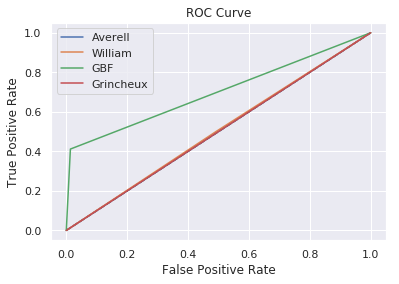

In [50]:

# diagonale : si on tombe en-dessous on est vraiment très nul
plt.plot([0, 1], [0, 1], 'k--')

for name, y_pred in [('Averell', averell), ('William', william), ('GBF', gbf), ('Grincheux', grincheux)]:
    fpr, tpr, thresholds = roc_curve(df_churn['churn'] == 'Yes', y_pred == 'Yes')
    plt.plot(fpr, tpr, label=name)
    
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.legend()

plt.show()

On voit directement qu'à part GBF, tout le monde fait aussi bien que de l'aléatoire...

Le score qui en découle (AUC) se calcule facilement.

In [51]:
from sklearn.metrics import roc_auc_score

In [53]:
pd.DataFrame({
    'Précision': [precision_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]],
    'Rappel': [recall_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]],
    'F1-score': [f1_score(df_churn['churn'], clf, pos_label="Yes") for clf in [averell, william, gbf, grincheux]],
    'ROC-AUC score': [roc_auc_score(df_churn['churn'] == 'Yes', clf == "Yes") for clf in [averell, william, gbf, grincheux]]
},
    index=['Averell', 'William', 'GBF', 'Grincheux']
).transpose()

/home/girardea/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/girardea/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,Averell,William,GBF,Grincheux
Précision,0.0,0.143436,0.833811,0.141400
Rappel,0.0,0.500707,0.411598,1.000000
F1-score,0.0,0.222992,0.551136,0.247766
ROC-AUC score,0.5,0.504139,0.699044,0.500000


**Quand utiliser le F1-score ou le ROC-AUC score ?**

Cela va dépendre du problème que vous adressez, et notamment :
* La classe que vous cherchez à trouver est-elle en grande proportion dans la population ?
* Êtes-vous plus soucieux des faux positifs ou des faux négatifs ?

Notez tout de même que le ROC-AUC score ne dépend pas du seuil choisi dans le classificateur. Au contraire, pour calculer le F1-score, il convient de caler ce paramètre finement auparavant.

Testez les deux scores et voyez lequel représente le mieux ce que vous cherchez à optimiser.